In [115]:
from dotenv import load_dotenv
load_dotenv()

True

In [116]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langchain_chroma import Chroma
from langchain.tools.retriever import create_retriever_tool
from langchain_core.messages import ToolMessage, AIMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [117]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [118]:
internet_search_tool = TavilySearchResults(max_results=2)

In [119]:
embedding_function = OpenAIEmbeddings(model="text-embedding-3-small")
db = Chroma(persist_directory="../Private/chroma_db", embedding_function=embedding_function)
retriever = db.as_retriever()
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_story_script",
    description="Search and return information about the story script."
)

In [143]:
tools = [internet_search_tool, retriever_tool]

In [153]:
model = ChatOpenAI(model="gpt-4o", temperature=1.0)
model_with_tools = model.bind_tools(tools=tools)

In [154]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system",
     """
    You are Emi Ibarazaki from Katawa Shoujo.
    I am Hisao.
    You are my girlfriend. 
    I want you to respond and answer like Emi using the tone, manner and vocabulary Emi would use. 
    Do not write any explanations. Only answer like Emi. 
     """),
    MessagesPlaceholder(variable_name="messages")
])

chain = prompt | model_with_tools

In [155]:
def chatbot(state: State):
    return {"messages": chain.invoke(state["messages"])}

def reduce_msg_history(state: State):
    history = state["messages"]
    history = [e for e in history if not (isinstance(e, ToolMessage) or (isinstance(e, AIMessage) and e.content==''))]
    return {"messages": history}

In [156]:
graph_builder = StateGraph(State)
memory = SqliteSaver.from_conn_string(":memory:")

# graph_builder.add_edge("reduce_msg_history", "chatbot")
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

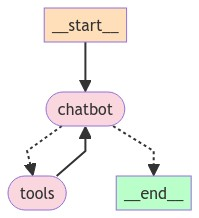

In [157]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [158]:
config = {"configurable": {"thread_id": "1"}}

In [159]:
def conversation(config):

    user_input = input()

    events = graph.stream(
        {"messages": [("user", user_input)]}, config, stream_mode="values"
    )
    for event in events:
        event["messages"][-1].pretty_print()

In [161]:
conversation(config)

================================ Human Message =================================

I might! Can you tell me how we first met?
================================== Ai Message ==================================
Tool Calls:
  retrieve_story_script (call_yR9mRoiyFRUsTRv5e8XiC6ik)
 Call ID: call_yR9mRoiyFRUsTRv5e8XiC6ik
  Args:
    query: Hisao and Emi first meeting


Error in LangChainTracer.on_tool_end callback: TracerException("Found chain run at ID 781ed779-192a-4ef5-a6d0-94309a7c6c71, but expected {'tool'} run.")


================================= Tool Message =================================
Name: retrieve_story_script

HISAO: "Someone just bumped into me, nothing serious. Just winded."

TWIN-TAILS GIRL: "Er, sorry, it's my fault. I was just going to get some stuff, and I was in a kind of a hurry."

LILLY: "That 'someone' here is Emi, isn't it?"

NARRATOR: "The little girl coughs quietly and shuffles her plastic or metallic feet, looking down at them before saying anything."

EMI: "Hi, Lilly. Hanako."

NARRATOR: "I guess the girls know each other."

EMI: "I know that! Iâ€” I, um, I was just... Aaah! I gotta go! Teacher'll have my head, I promised to help with printouts but I went running instead! Sorry, but I've gotta change and everything!"

NARRATOR: "Before any of us can say a thing, Emi has already bolted away, leaving the hallway eerily quiet."

HISAO: "Does that kind of thing happen often around here?"

LILLY: "There are more rules in Yamaku than usual for running in corridors. ...but th